<a href="https://colab.research.google.com/github/sourit123/Sourit-Khamaru/blob/main/Pneumonia_healthcare_project_Sourit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Title: Pneumonia Detection with Model Uncertainty Estimation
Project Description: Develop a model to classify chest X-ray images as either pneumonia or normal and incorporate an uncertainty estimation mechanism. This approach not only detects pneumonia but also provides a confidence score for each prediction, helping identify cases where the model is less certain.

In [ ]:
# Import required libraries
import pathlib
import cv2
from sklearn.model_selection import train_test_split
import os
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, callbacks, metrics, regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score, auc, precision_score, f1_score, recall_score, accuracy_score
from google.colab import drive
import zipfile
import seaborn as sns

In [ ]:
!pip install kaggle
drive.mount("/content/drive")
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
with open("chest-xray-pneumonia.zip", "rb") as file:
  zipfile.ZipFile(file).extractall("/content/data")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:29<00:00, 127MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.4MB/s]


In [ ]:
def get_data(path):
    positive = path/"PNEUMONIA"
    negative = path/"NORMAL"
    im_positive_path = [*positive.glob("*.jpeg")]
    im_negative_path = [*negative.glob("*.jpeg")]
    im_path = im_positive_path + im_negative_path
    y = np.ones(len(im_path), dtype=int)
    y[len(im_positive_path):] = 0
    X = np.array([cv2.resize(cv2.imread(str(img), flags=cv2.IMREAD_GRAYSCALE),
    (256, 256)) for img in im_path])
    return X, y

root = pathlib.Path("/content/data/chest_xray")
train_path = root/"train"
test_path = root/"test"
val_path = root/"val"

X_train, y_train = get_data(train_path)
X_test, y_test = get_data(test_path)
X_val, y_val = get_data(val_path)


In [ ]:
class_names = ["Normal", "Pneumonia"]
class_counts = pd.Series(np.bincount(y_train)).rename("train").to_frame()\
.merge(pd.Series(np.bincount(y_val)).rename("validation"), right_index=True,
       left_index=True)\
.merge(pd.Series(np.bincount(y_test)).rename("test"), right_index=True,
       left_index=True)\
.rename(index={0:"normal", 1:"pneumonia"}).T

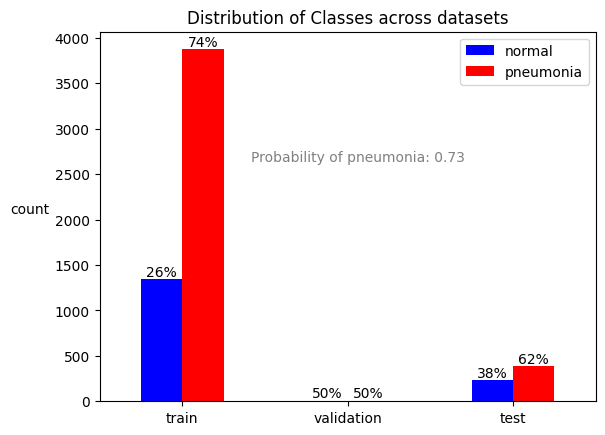

In [ ]:
ax=plt.subplot()
class_counts.plot(kind="bar", ax=ax, color=["blue", "red"])
percent = (class_counts.iloc[:, 0] / class_counts.sum(axis=1)).map("{:.0%}".format)
ax.bar_label(ax.containers[0], percent)
percent = (class_counts.iloc[:, 1] / class_counts.sum(axis=1)).map("{:.0%}".format)
ax.bar_label(ax.containers[1], percent)

total_percent = class_counts.loc[:, "pneumonia"].sum()/class_counts.sum().sum()
ax.annotate(text="Probability of pneumonia: {}".format(total_percent.round(2)), xy=(ax.get_xlim()[1]/6, ax.get_ylim()[1]*.65), color="gray")

ax.set_title("Distribution of Classes across datasets")
ax.tick_params(labelrotation=0)
ax.set_ylabel("count", rotation=0)
ax.axes.yaxis.label.set_ha("right")
plt.show()

In [ ]:
from pathlib import Path

def check_split_counts(root_dir):
    split_counts = {}
    for split in ["train", "test", "val"]:
        split_path = Path(root_dir) / split
        normal_count = len(list((split_path / "NORMAL").glob("*.jpeg")))
        pneumonia_count = len(list((split_path / "PNEUMONIA").glob("*.jpeg")))

        split_counts[split] = {
            "Normal": normal_count,
            "Pneumonia": pneumonia_count,
            "Total": normal_count + pneumonia_count
        }

    return pd.DataFrame(split_counts).T

# Root directory where the chest_xray data is stored
root_dir = "/content/data/chest_xray"
split_summary = check_split_counts(root_dir)
print(split_summary)


       Normal  Pneumonia  Total
train    1341       3875   5216
test      234        390    624
val         8          8     16


In [ ]:
# 1. Data Preprocessing
print("Starting Data Preprocessing...")

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Starting Data Preprocessing...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


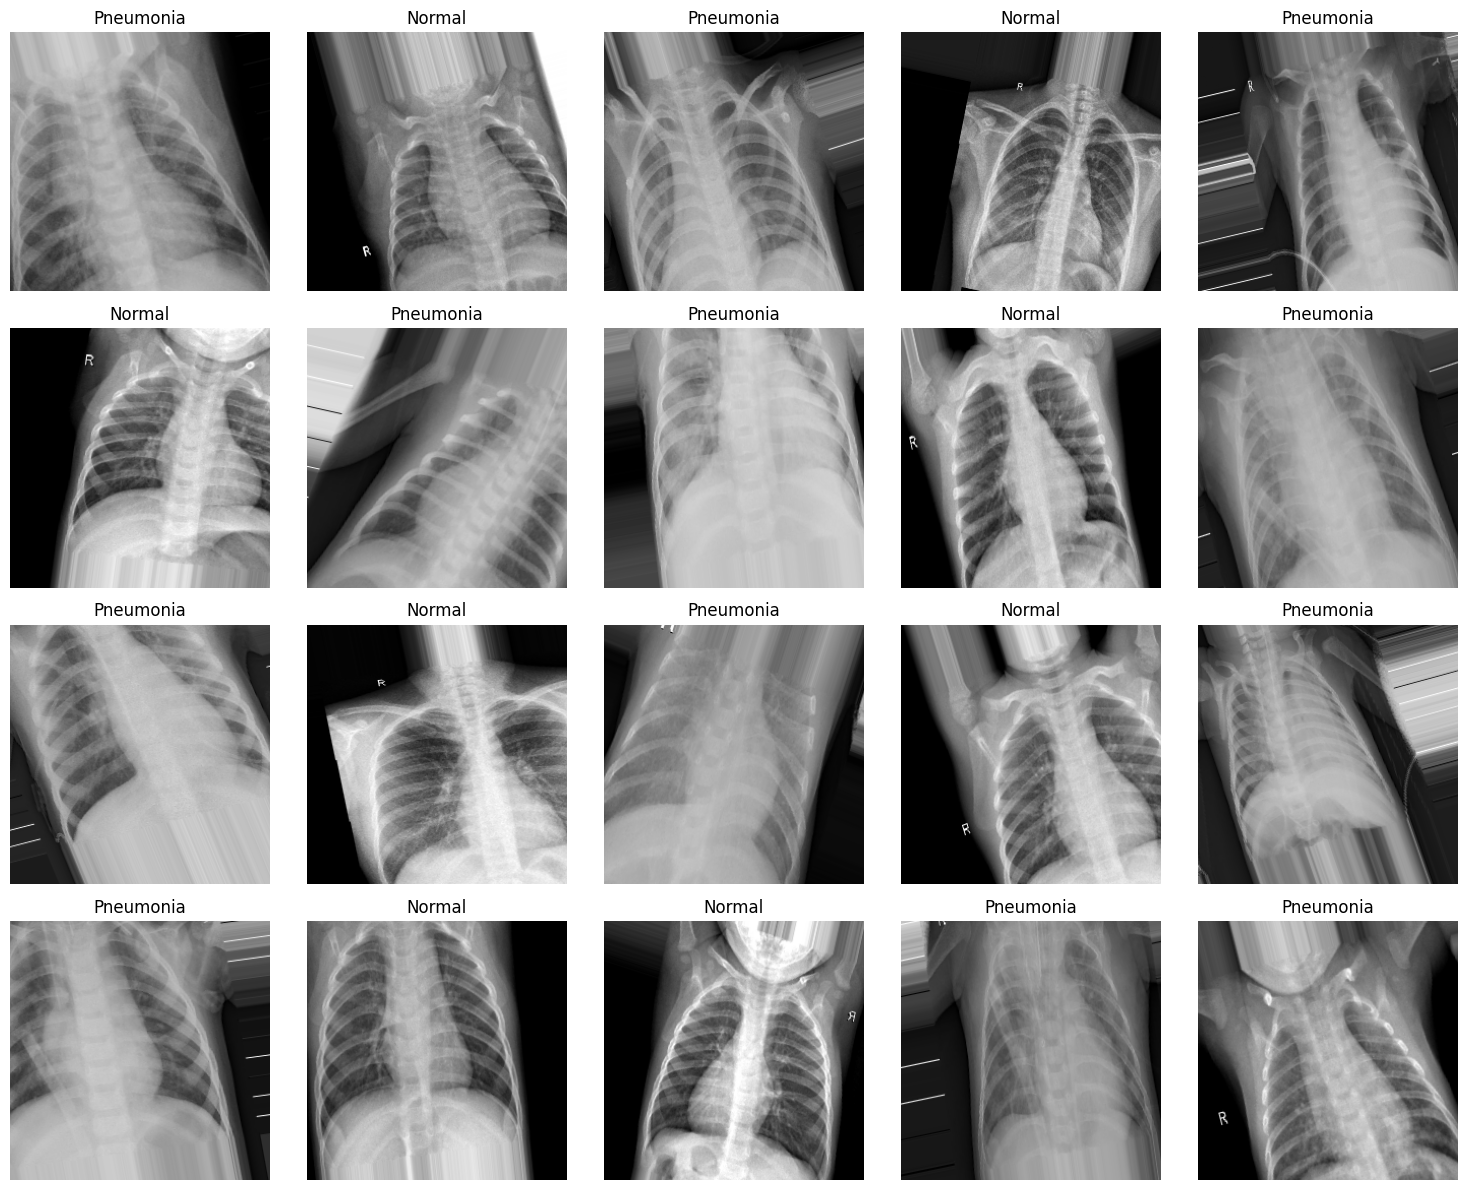

In [ ]:
# Get a batch of normalized images and their labels
images, labels = next(train_generator)

# Set up the plot grid
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

# Display 20 images
for i in range(20):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title('Pneumonia' if labels[i] == 1 else 'Normal')

plt.tight_layout()
plt.show()


In [ ]:
# 2. Pneumonia Detection: Model Development
print("Building the CNN Model...")

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # For uncertainty estimation
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_model()
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Building the CNN Model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,452,353 (13.17 MB)

 Trainable params: 3,452,353 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

None


Training the Model...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 713ms/step - accuracy: 0.7493 - loss: 0.5319 - val_accuracy: 0.6250 - val_loss: 0.6532
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 719ms/step - accuracy: 0.8567 - loss: 0.3127 - val_accuracy: 0.7500 - val_loss: 0.5253
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 695ms/step - accuracy: 0.8670 - loss: 0.2870 - val_accuracy: 0.6250 - val_loss: 0.6537
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 706ms/step - accuracy: 0.8740 - loss: 0.2920 - val_accuracy: 0.6250 - val_loss: 0.5984
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 702ms/step - accuracy: 0.8812 - loss: 0.2708 - val_accuracy: 0.8125 - val_loss: 0.4313


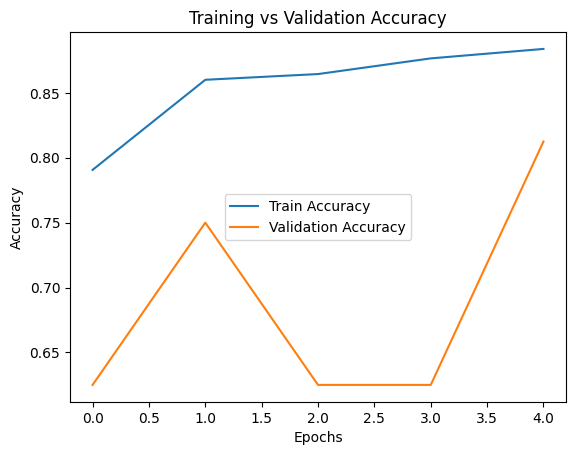

In [ ]:
# Model Training
print("Training the Model...")
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [ ]:

# 3. Uncertainty Estimation
print("Estimating Model Uncertainty...")

def monte_carlo_predictions(model, data_generator, num_samples=50):
    predictions = []
    for _ in range(num_samples):
        predictions.append(model.predict(data_generator, verbose=0))
    predictions = np.array(predictions)
    mean_predictions = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0)
    return mean_predictions, uncertainty

# Monte Carlo Dropout Predictions
mean_predictions, uncertainties = monte_carlo_predictions(model, test_generator)

# Confidence Scores
confidence_scores = 1 - uncertainties
print("Confidence Scores Calculated.")

Estimating Model Uncertainty...
Confidence Scores Calculated.


In [ ]:
# 4. Evaluation
print("Evaluating the Model...")

# Binary predictions based on threshold
binary_predictions = (mean_predictions > 0.5).astype(int)

# Classification Metrics
y_true = test_generator.classes
print("Classification Report:")
print(classification_report(y_true, binary_predictions))

Evaluating the Model...
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       234
           1       0.94      0.80      0.87       390

    accuracy                           0.85       624
   macro avg       0.84      0.86      0.84       624
weighted avg       0.87      0.85      0.85       624



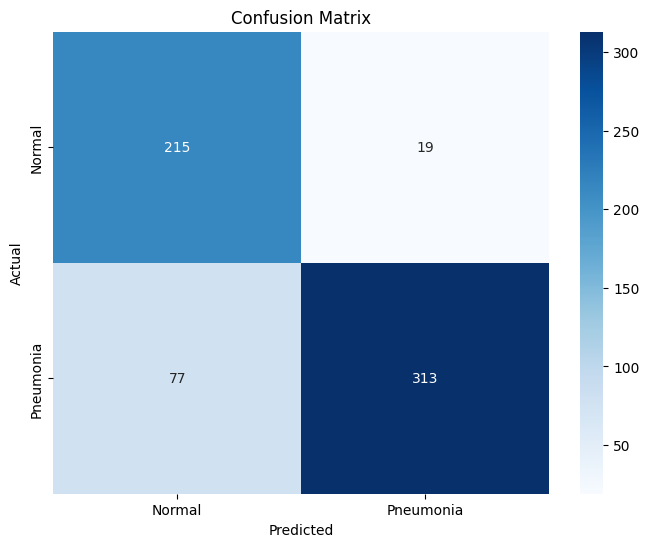

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, binary_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Accuracy from Confusion Matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.2f}")

# Precision, Recall, and F1-Score
precision = precision_score(y_true, binary_predictions)
recall = recall_score(y_true, binary_predictions)
f1 = f1_score(y_true, binary_predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.85
Precision: 0.94
Recall: 0.80
F1-Score: 0.87


In [ ]:
# ROC-AUC
roc_auc = roc_auc_score(y_true, mean_predictions)
print(f"ROC-AUC: {roc_auc:.2f}")

# Analysis of Confidence Scores
low_confidence_indices = np.where(confidence_scores < 0.7)[0]
print(f"Number of low-confidence predictions: {len(low_confidence_indices)}")
print(f"Low-confidence samples indices: {low_confidence_indices}")

ROC-AUC: 0.94
Number of low-confidence predictions: 0
Low-confidence samples indices: []


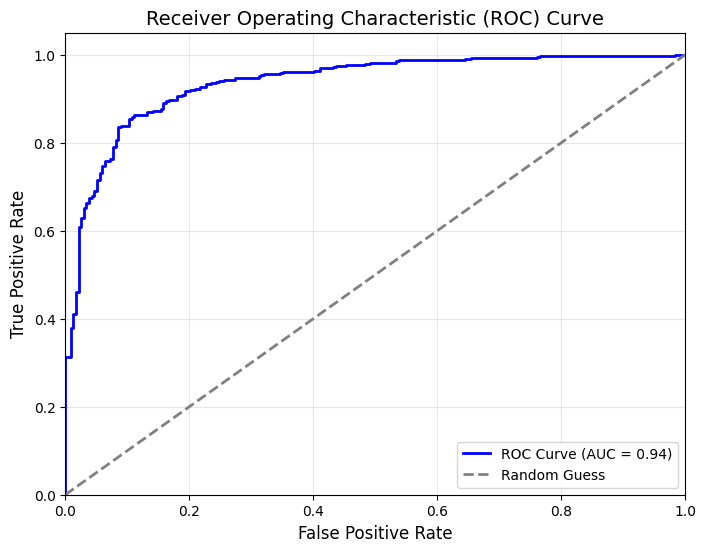

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, mean_predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
